<a href="https://colab.research.google.com/github/dtabuena/EphysLib/blob/main/Synapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'EphysLib'...
remote: Enumerating objects: 1059, done.
remote: Counting objects: 100% (436/436), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 1059 (delta 323), reused 230 (delta 193), pack-reused 623
Receiving objects: 100% (1059/1059), 14.78 MiB | 3.06 MiB/s, done.
Resolving deltas: 100% (700/700), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
##### Setup Protocol List
VC_prot = ['VC - MemTest-10ms-160ms',
           'VC - Multi IV - 150ms',]
IC_prot = ['IC - Gain - D20pA',
           'IC - Gain - D50pA',
           'IC - Rheobase',
           'IC - R input',
           'IC - Latentcy 800pA-1s'
           'VC - 3min GapFree',
           'I0 - 3min GapFree']

In [22]:
dataset = {'data_name': 'Today',
           'data_source': "https://www.dropbox.com/sh/wnbpd76u1v28qnz/AADD0BDu0BF81SAlN4Q6QxFea?dl=0",
           'file_naming_scheme': ['Rec_date','GenoType','Sex','Age','Slice_Num','Cell_num','Cell_Type'],
           }
           
data_name = dataset['data_name']
data_source = dataset['data_source']
file_naming_scheme = dataset['file_naming_scheme']

''' Gather and Catalog Source Data'''
file_loc = get_drobox_folder(data_source, 'my_ephys_data_' + data_name)
clear_output(wait=False)   
abf_recordings_df, protocol_set = catalogue_recs(file_loc,file_naming_scheme)
print(protocol_set)

['VC - 3min GapFree', 'VC - MemTest-10ms-160ms', 'IC - R input', 'VC - Multi IV - 450ms', 'IC - Gain - D10pA', 'VC - 70mV - 3min GapFree', 'IC - Latentcy 800pA-1s', 'IC - Rheobase', 'VC - Multi IV - 150ms', 'I0 - 3min GapFree']


In [23]:

display(abf_recordings_df.columns)

Index(['Recording_name', 'cell_id', 'Rec_date', 'GenoType', 'Sex', 'Age',
       'Slice_Num', 'Cell_num', 'Cell_Type', 'protocol', 'abf_timestamp',
       'channelList'],
      dtype='object')

In [66]:
synapse = ['VC - 70mV - 3min GapFree', 'VC - 3min GapFree']
# for r in abf_recordings_df.index:
#     if abf_recordings_df.loc[r,'protocol'] in synapse:
#         print(r)
        
abf_list = [r for r in abf_recordings_df.index if abf_recordings_df.loc[r,'protocol'] in synapse]


my_ephys_data_Today/2023x04x12_E4KI_F_P236_s001_c003_DG_0003.abf
-4sd: -5.46953611894882
(168, 300)


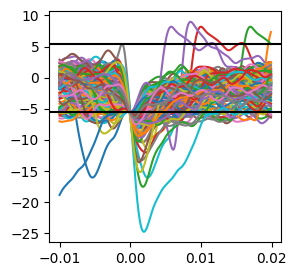

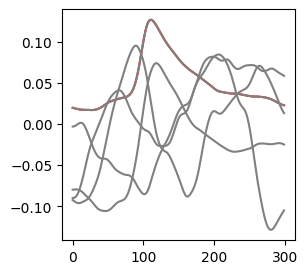

In [104]:
import scipy as sc




def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = np.min([1-1/fs,highcut / nyq])
    b, a = sc.signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = sc.signal.filtfilt(b, a, data)

    b_notch,a_notch = sc.signal.iirnotch(50, 20, fs=fs)
    data = sc.signal.filtfilt(a_notch, a_notch, data)
    data = data-np.mean(data)
    return data

def filter_for_PSCs(abf, lowcut, highcut,):
    time = abf.sweepX
    response = abf.sweepY
    holding = abf.sweepC
    fs=abf.sampleRate
    response_f1 = butter_bandpass_filter(response, lowcut, highcut, fs  ) 
    response_f2 = butter_bandpass_filter(response, .01, 5000, fs  )
    
    # fig,ax = plt.subplots(1,figsize=[16,3])
    # ax.plot(time,response_f2,'k')
    # ax.plot(time,response_f1,'r')
    x0 = np.random.choice(time,1)
    x0 = 25.25
    dur = 3
    xlims = x0 +np.array([0,dur])
    # ax.set_xlim(xlims)
    # ax.set_ylim([-30,10])

    return response_f1




def make_template(stack_np,to_plot=False):
    U, S, Vh = sc.linalg.svd(stack_np,full_matrices=False)
    u_1, s_1, vh_1 = sc.sparse.linalg.svds(stack_np,k=1)    
    u_5, s_5, vh_5 = sc.sparse.linalg.svds(stack_np,k=5)
    stack_reduced = u_1 @ np.diag(s_1) @ vh_1
    template = vh_1.T.flatten()
    if to_plot:
        fig,ax =plt.subplots(1,figsize=[3,3])
        ax.plot(template,'r')
        ax.plot(vh_5.T,'grey')
    return template, template/np.sum(template)


def search_for_template(trace,fs, template,corr_thresh=3,window=[-0.015,0.02]):
    fig,ax = plt.subplots(1,figsize=[3,3])
    corr = np.correlate(trace , template, mode='same')
    is_corr_event = corr>corr_thresh
    is_corr_event = np.diff(is_corr_event,prepend=0)>0
    event_inds = np.where(is_corr_event)[0]
    time_wind = np.arange(window[0],window[1],1/fs)    
    corr_stack =  window_stack(corr,[window[0]*fs,window[1]*fs],event_inds)
    max_corr = np.max(corr_stack,axis=1)
    for r in range(len(max_corr)):
        shift = np.where(corr_stack[r,:] == max_corr[r] )[0][0]
        event_inds[r] = event_inds[r] + (shift + window[0]*fs) 
        
    stack = window_stack(trace,[window[0]*fs,window[1]*fs],event_inds)
    epsc_mean = np.median(stack,axis=0)
    epsc_std = np.std(stack,axis=0)
    ax.plot(time_wind,stack.T,'grey')
    ax.plot(time_wind,epsc_mean,color='red')
    ax.plot(time_wind,epsc_mean+epsc_std,color='k')
    ax.plot(time_wind,epsc_mean-epsc_std,color='k')
    plt.show()
    return {'stack':stack, 'epsc_mean':epsc_mean, 'epsc_std':epsc_std,'event_inds':event_inds}


def window_stack(trace,ind_range,inds):
    window = np.arange(ind_range[0],ind_range[1],dtype='int')
    stack = []
    for i in inds:
        indx_wind = i + window
        try:
            i_trace = trace[indx_wind]
            stack.append(i_trace)
        except: None    
    stack = np.stack(stack)
    return stack


def plot_raw(abf,t_range='all',num_rows=80,raster_t=[]):
    if 'all' in t_range:
        t_range= [0, abf.sweepX[-1]]
    response_f1 = filter_for_PSCs(abf, lowcut = .5, highcut = 100)

    trim_resp = response_f1[np.logical_and(abf.sweepX>t_range[0], abf.sweepX<t_range[1])]
    trim_time = abf.sweepX[np.logical_and(abf.sweepX>t_range[0], abf.sweepX<t_range[1])]
    trim_time =trim_time-trim_time[0]
    sd=np.std(trim_resp)
    norm_resp = trim_resp/sd/3

    fig,ax=plt.subplots(1,figsize=(20,0.25*num_rows))
    row_len = int(len(trim_resp)/num_rows)
    row_ind = np.arange(row_len)
    t_wind = np.arange(row_len)/abf.sampleRate
    # try:
    for r in np.arange(num_rows):
        offset = - r*4
        y_ind = row_len*(r+1)  + row_ind
        is_valid = y_ind<len(norm_resp)
        y_ind=y_ind[is_valid]     
        y_wind = norm_resp[y_ind] + offset
        ax.plot(t_wind[is_valid],y_wind,zorder=5)
        ax.plot(t_wind, offset * np.ones_like(t_wind),':k' ,zorder=-5)

        x_wind = abf.sweepX[y_ind]
        for x in x_wind:
            if x in raster_t:
                x_ind = np.where(x_wind==x)[0][0]
                ax.scatter(t_wind[x_ind],offset,color='red')

    return None



def psc_wrapper(abf,sd_thresh=[-4,4],window=[-0.015,0.02]):
    response_f1 = filter_for_PSCs(abf, lowcut = .5, highcut = 300)
    exit_stack = find_events(response_f1, abf.sampleRate, np.min(sd_thresh),window=window)
    _,exit_template=make_template(exit_stack,to_plot=True)
    # exit_results=search_for_template(response_f1,abf.sampleRate, exit_template, corr_thresh=3,window=window)
    # # inhib_stack = find_events(-response_f1, abf.sampleRate, -np.max(sd_thresh))

    # exit_event_times = abf.sweepX[exit_results['event_inds']]
    # plot_raw(abf,raster_t = exit_event_times)        


    return exit_results



def find_events(response_f1,fs, sd_thresh = 5,cool_down_time=0,to_plot= True,window=[-0.015,0.02]):
    sd = np.std(response_f1)
    print(str(sd_thresh)+'sd:',sd*sd_thresh)
    cool_down_idx = cool_down_time*fs


    if sd_thresh>0: is_event= response_f1 > sd*sd_thresh
    if sd_thresh<0: is_event= response_f1 < sd*sd_thresh

    event_start = np.diff(is_event,prepend=0)>0
    starts = np.where(event_start)[0]



    x0t = window[0]
    x1t = window[1]
    x0n = x0t*fs
    x1n = x1t*fs

    fig,ax = plt.subplots(1,figsize=[3,3])
    time_wind = np.arange(x0t,x1t,1/fs)
    stack = []
    for e in starts:    
        indx_wind = e + np.arange(x0n,x1n,dtype=int)
        try:
            resp_wind = response_f1[indx_wind]
            ax.plot(time_wind,resp_wind)
            stack.append(resp_wind)
        except: None
        
    ax.axhline(sd*sd_thresh,color='k')
    ax.axhline(-sd*sd_thresh,color='k')
    stack_np = np.stack(stack,axis=0)
    print(stack_np.shape)

    return stack_np


to_plot= True
my_abf = abf_list[6]
print(my_abf)
abf=abf_or_name(my_abf)


exit_results = psc_wrapper(abf,sd_thresh=[-4,4],window=[-.01,0.02])

# time = abf.sweepX
# response = abf.sweepY
# holding = abf.sweepC
# fs=abf.sampleRate





# response_f1 = filter_for_PSCs(abf, lowcut = .5, highcut = 1000)
# stack_np = find_events(response_f1,fs, sd_thresh = 4,cool_down_time = 0.005 , to_plot= True)
# _,template = make_template(stack_np)
# res = search_for_template(response_f1, -template, corr_thresh=3)

